# Data Preprocessing Function

In [70]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.feature_selection import mutual_info_classif # type: ignore
import time

np.random.seed(112)

In [71]:
from sklearn.impute import SimpleImputer # type: ignore
def load_and_preprocess_dataset_one():
    # load the data into a dataframe
    df = pd.read_csv('TelcoCustomerChurn.csv')

    # replace ' ' values with NaN
    df['TotalCharges'].replace(' ', np.nan, inplace=True)

    # imputation
    mean_imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

    # Fit transform the imputer object on the columns with missing values
    df['TotalCharges'] = mean_imputer.fit_transform(df['TotalCharges'].values.reshape(-1,1))

    # drop the customerID column
    df.drop('customerID', axis=1, inplace=True)

    # modifying
    df['MultipleLines'].replace('No phone service', 'No', inplace=True)
    for i in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
        df[i].replace('No internet service', 'No', inplace=True)
    
    # Modify the target column values
    df['Churn'].replace({'Yes':1, 'No':0}, inplace=True)

    # Separate the features and target
    y = df['Churn']
    X = df.drop('Churn', axis=1)

    # One-hot encoding using pandas
    X = pd.get_dummies(X, columns=['InternetService', 'Contract', 'PaymentMethod']) # these columns have more than 2 categories
    X = pd.get_dummies(X, drop_first=True).astype('float64') # these columns have only 2 categories

    # Split the data into train and test sets in 80-20 ratio

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

    # Scale the numerical features
    scaler = StandardScaler()   # z-score standardization: (x - mean) / std
    columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

    # Fit and transform the training data, save the scaling parameters for future use in test data
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_test[columns] = scaler.transform(X_test[columns])

    # print(type(X_train), type(X_test), type(y_train), type(y_test))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test # dataframes and series


In [72]:
def load_and_preprocess_dataset_two():
    # Column names for the data
    columns = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]

    # Load the data into a dataframe
    df_train = pd.read_csv('adult.data', names=columns)
    df_test = pd.read_csv('adult.test', names=columns)
    df_test.drop(0, axis=0, inplace=True)  # Drop header row from test set

    # Impute ' ?' values with mode of the column
    for column in df_train.columns:
        df_train[column].replace(' ?', df_train[column].mode()[0], inplace=True)
        df_test[column].replace(' ?', df_test[column].mode()[0], inplace=True)

    # Modify the output column values to 0 and 1
    df_train['income'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)
    df_test['income'].replace({' <=50K.': 0, ' >50K.': 1}, inplace=True)

    # Separate features and target
    y_train = df_train['income'].values  # Convert to NumPy array
    X_train = df_train.drop('income', axis=1)

    y_test = df_test['income'].values  # Convert to NumPy array
    X_test = df_test.drop('income', axis=1)

    # Find out the categorical columns (excluding 'sex')
    categorical_columns = X_train.select_dtypes(include=['object'])
    categorical_columns.drop(['sex'], axis=1, inplace=True)

    # One-hot encoding for 'sex' and other categorical columns
    X_train = pd.get_dummies(X_train, drop_first=True, columns=['sex'])
    X_train = pd.get_dummies(X_train, columns=categorical_columns.columns.to_list()).astype('float64')

    X_test = pd.get_dummies(X_test, drop_first=True, columns=['sex'])
    X_test = pd.get_dummies(X_test, columns=categorical_columns.columns.to_list()).astype('float64')

    # Drop columns not present in both train and test sets
    if 'native-country_ Holand-Netherlands' in X_train.columns:
        X_train.drop(['native-country_ Holand-Netherlands'], axis=1, inplace=True)

    # Ensure test set has the same columns as the training set
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0  # Add missing columns as 0 for test set
    
    # Ensure the columns in the test set are in the same order as the training set
    X_test = X_test[X_train.columns]

    # Scale the numerical features
    scaler = StandardScaler()
    numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    # Fit and transform the training data, then transform the test data
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Convert everything to NumPy arrays
    X_train = X_train.values
    X_test = X_test.values

    return X_train, X_test, y_train, y_test


In [73]:
def load_and_preprocess_dataset_three():
    # Load the data into a dataframe
    df = pd.read_csv('creditcard.csv')

    # Separate the positive and negative samples
    positive_samples = df[df['Class'] == 1]
    negative_samples = df[df['Class'] == 0].sample(n=20000, random_state=112)  # Sample 20,000 negative instances

    # Combine the positive and sampled negative samples
    df_downsampled = pd.concat([positive_samples, negative_samples])

    # Separate features and target
    y = df_downsampled['Class'].astype('float64')
    X = df_downsampled.drop('Class', axis=1)

    # Split into train and test sets in 80-20 ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=112, stratify=y)

    # Scale the numerical features
    scaler = StandardScaler()
    columns = X_train.columns

    # Fit and transform the training data, save the scaling parameters for future use in test data
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_test[columns] = scaler.transform(X_test[columns])

    return X_train, X_test, y_train, y_test  # dataframes


In [74]:
import numpy as np # type: ignore

class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return np.array([1 if i > 0.5 else 0 for i in y_predicted])

    
    


In [75]:
# For dataset 1 and 3
# def bootstrap_sample(X, y):
#     n_samples = X.shape[0]
#     indices = np.random.choice(n_samples, size=n_samples, replace=True)
    
#     # Ensure that X is indexed correctly
#     return X.iloc[indices], y.iloc[indices]


In [76]:
# For dataset 2

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    
    # Use NumPy-style indexing instead of .iloc
    return X[indices], y[indices]

In [77]:
def bagging(X, y, n_estimators=9, learning_rate=0.1, n_iterations=1000):
    models = []

    for i in range(n_estimators):
        # Generate bootstrap sample
        X_sample, y_sample = bootstrap_sample(X, y)
        
        # Train logistic regression on the bootstrap sample
        model = LogisticRegression(learning_rate=learning_rate, n_iterations=n_iterations)
        model.fit(X_sample, y_sample)
        
        # Append the trained model to the list
        models.append(model)
    
    return models


In [78]:
def stacking_with_bagging_models(bagging_models, X_train, y_train, X_test, y_test, learning_rate=0.1, n_iterations=1000):
    # Number of bagging models
    n_estimators = len(bagging_models)
    
    # Initialize meta-features (predictions of base models)
    meta_X_train = np.zeros((X_train.shape[0], n_estimators))
    meta_X_test = np.zeros((X_test.shape[0], n_estimators))
    
    # Use the bagging models to create meta-features
    for i, model in enumerate(bagging_models):
        # Base models make predictions on the original training set and test set
        meta_X_train[:, i] = model.predict(X_train)
        meta_X_test[:, i] = model.predict(X_test)
    
    # Train the meta-model (typically Logistic Regression) on meta-features
    meta_model = LogisticRegression(learning_rate=learning_rate, n_iterations=n_iterations)
    meta_model.fit(meta_X_train, y_train)
    
    # Meta-model makes final predictions on test set
    final_predictions = meta_model.predict(meta_X_test)
    
    return meta_model, final_predictions


In [79]:
import numpy as np # type: ignore

def majority_voting(bagging_models, X_test):
    # Collect predictions from all bagging models
    predictions = np.zeros((X_test.shape[0], len(bagging_models)))
    
    for i, model in enumerate(bagging_models):
        predictions[:, i] = model.predict(X_test)
    
    # Majority vote: For each row (sample), take the most common prediction
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
    
    return final_predictions


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score # type: ignore

# Bagging function for LR
def bagging_lr(X_train, y_train, X_test, y_test, n_estimators=9, learning_rate=0.01, n_iterations=1000):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []
    pr_aucs = []

    # Generate n_estimators LR models
    models = bagging(X_train, y_train, n_estimators=n_estimators, learning_rate=learning_rate, n_iterations=n_iterations)

    for model in models:
        y_pred = model.predict(X_test)
        
        # Collect metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        roc_aucs.append(roc_auc_score(y_test, y_pred))
        pr_aucs.append(average_precision_score(y_test, y_pred))

    # Return average and standard deviation of each metric
    return {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1s), np.std(f1s)),
        'roc_auc': (np.mean(roc_aucs), np.std(roc_aucs)),
        'pr_auc': (np.mean(pr_aucs), np.std(pr_aucs))
    }


In [81]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore

def plot_violin(metrics_dict):
    """
    Function to plot violin plots for the performance metrics of the 9 bagging LR learners.
    
    Parameters:
    - metrics_dict: A dictionary containing lists of metrics for each learner.
      Keys: 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc'
    """
    # Convert metrics to DataFrame for easier plotting
    df = pd.DataFrame(metrics_dict)
    
    # Create a new figure
    plt.figure(figsize=(12, 8))
    
    # Plot violin plots manually using matplotlib
    for i, metric in enumerate(df.columns):
        plt.subplot(2, 3, i + 1)
        plt.violinplot(df[metric], showmeans=True)
        plt.title(metric)
        plt.xlabel('Metric')
        plt.ylabel('Value')
    
    # Customize the plot
    plt.suptitle("Violin Plots of Performance Metrics for 9 Bagging LR Learners")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Display the plot
    plt.show()

# Example usage
def bagging_lr_metrics(X_train, y_train, X_test, y_test, n_estimators=9, learning_rate=0.01, n_iterations=1000):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []
    pr_aucs = []

    # Generate n_estimators LR models
    models = bagging(X_train, y_train, n_estimators=n_estimators, learning_rate=learning_rate, n_iterations=n_iterations)

    for model in models:
        y_pred = model.predict(X_test)
        
        # Collect metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        roc_aucs.append(roc_auc_score(y_test, y_pred))
        pr_aucs.append(average_precision_score(y_test, y_pred))

    # Prepare metrics for plotting
    metrics_dict = {
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1s,
        'ROC AUC': roc_aucs,
        'PR AUC': pr_aucs
    }

    # Call the violin plot function
    plot_violin(metrics_dict)


In [82]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

# Define evaluation function
def evaluate_model(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred),
        'pr_auc': average_precision_score(y_true, y_pred)
    }

# Define function to get metrics for LR Bagging, Voting, and Stacking
def collect_metrics(X_train, X_test, y_train, y_test, n_estimators=9, learning_rate=0.01, n_iterations=1000):
    # Bagging LR
    bagging_results = bagging_lr(X_train, y_train, X_test, y_test, n_estimators, learning_rate, n_iterations)
    #bagging_metrics = {metric: bagging_results[metric][0] for metric in bagging_results}
    bagging_metrics = {metric: bagging_results[metric][0] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']}


    # Voting Ensemble
    bagging_models = bagging(X_train, y_train, n_estimators, learning_rate, n_iterations)
    voting_predictions = majority_voting(bagging_models, X_test)
    voting_metrics = evaluate_model(y_test, voting_predictions)

    # Stacking Ensemble
    meta_model, stacking_predictions = stacking_with_bagging_models(bagging_models, X_train, y_train, X_test, y_test, learning_rate, n_iterations)
    stacking_metrics = evaluate_model(y_test, stacking_predictions)

    return {
        'Bagging LR': bagging_metrics,
        'Voting Ensemble': voting_metrics,
        'Stacking Ensemble': stacking_metrics
    }

# Load datasets and preprocess
# Example for Dataset 1
#X_train1, X_test1, y_train1, y_test1 = load_and_preprocess_dataset_one()
#metrics1 = collect_metrics(X_train1, X_test1, y_train1, y_test1)

# Example for Dataset 2
X_train2, X_test2, y_train2, y_test2 = load_and_preprocess_dataset_two()
metrics2 = collect_metrics(X_train2, X_test2, y_train2, y_test2)

# Example for Dataset 3
#X_train3, X_test3, y_train3, y_test3 = load_and_preprocess_dataset_three()
#metrics3 = collect_metrics(X_train3, X_test3, y_train3, y_test3)

# Create DataFrame for the results
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC'],
    #'Dataset 1 (Bagging LR)': [metrics1['Bagging LR'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    #'Dataset 1 (Voting)': [metrics1['Voting Ensemble'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    #'Dataset 1 (Stacking)': [metrics1['Stacking Ensemble'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    'Dataset 2 (Bagging LR)': [metrics2['Bagging LR'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    'Dataset 2 (Voting)': [metrics2['Voting Ensemble'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    'Dataset 2 (Stacking)': [metrics2['Stacking Ensemble'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    #'Dataset 3 (Bagging LR)': [metrics3['Bagging LR'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    #'Dataset 3 (Voting)': [metrics3['Voting Ensemble'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
    #'Dataset 3 (Stacking)': [metrics3['Stacking Ensemble'][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']],
})

# Print the DataFrame
print(metrics_df.to_string(index=False))


C:\Users\sizan\AppData\Local\Temp\ipykernel_11328\2053929704.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[column].replace(' ?', df_train[column].mode()[0], inplace=True)
C:\Users\sizan\AppData\Local\Temp\ipykernel_11328\2053929704.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

   Metric  Dataset 2 (Bagging LR)  Dataset 2 (Voting)  Dataset 2 (Stacking)
 Accuracy                0.826676            0.826362              0.825809
Precision                0.717861            0.720658              0.720910
   Recall                0.438753            0.432657              0.428497
 F1 Score                0.544597            0.540699              0.537508
  ROC AUC                0.692705            0.690394              0.688595
   PR AUC                0.447533            0.445819              0.443912


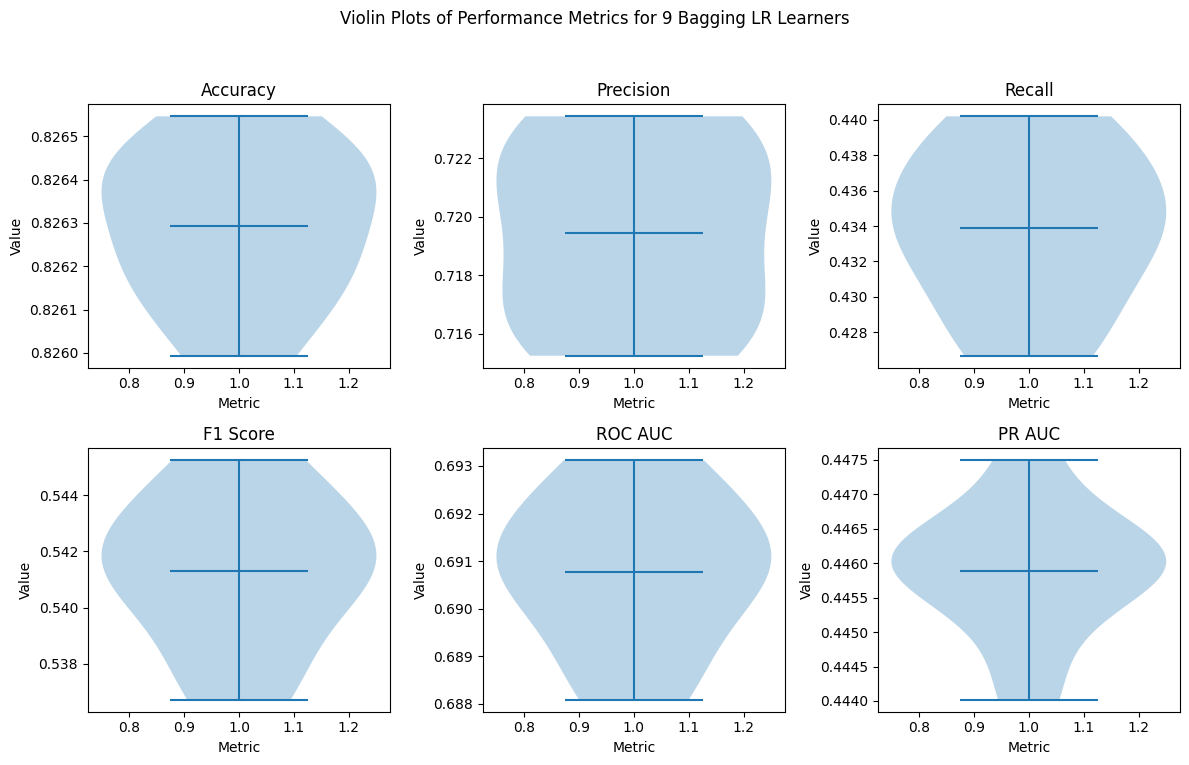

In [83]:
bagging_lr_metrics(X_train2, y_train2, X_test2, y_test2, n_estimators=9, learning_rate=0.01, n_iterations=1000)